## Utilisation du Notebook
- Exécuter les différentes cellules pour un fichier de calibration
- Noter la valeur de calibration obtenue et mettre à jour sa valeur dans *calib*
- Vérifier en relançant la cellule *Angle*, que l'angle est bien de 90° (réference 1) / 0° (référence 2)
- Un bon moyen de vérifer que la calibration est effectivement correcte est d'activer l'option *sig*
pour afficher les enveloppes des 2 antennes et de vérifier qu'après calibration, elles soient bien en phase.
- Ré-exécuter l'ensemble des cellules pour le ficher souhaité

Attention aux **références** ! 

- Référence 1 : $\phi \triangleq \angle (\hat{u} , \vec{r}_m)$ $\Rightarrow$ Erreur à 90° près.
- Référence 2 : $\phi \triangleq \angle (\hat{u} , \hat{n})$ , où $\hat{n}$ est la normale au plan des antennes. $\Rightarrow$ Erreur au signe près.



### Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import matplotlib.animation as animation
import os
from scipy.signal import argrelextrema
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
import matplotlib.colors as mcolors
# %matplotlib widget

### Options

In [2]:
Process = True                   #lancer l'extraction et le processing du fichier
# file = "angle30.npz"
# file = "Mesures_CapScience1/CSm_6m6m_-30and30_equal.npz"
file = "Mesures_CapScience1/CSm_straightline_4m-4m.npz"

# Affichage
video = False                    # Gif Range-Doppler map
imshow = False                   # Range Doppler map pour une frame 
sig = False                      # Plot des 2 enveloppes (antenne 1 et 2)
angle = False                    # Plot de l'angle à chaque frame et sa moyenne
plotXY = True                    # Plot des différentes cible en mode X-Y
plotDV = True                    # Plot des différentes cible en mode D-V

# Options du système
calibration = False              # Fichier de calibration
delete_pause = True              # Retirer les pauses entre les chirps ?
Angle = False                    # Calcul la moyenne du max de l'angle

d_connue = 5                     # Distance connue pour la calibration
prec = 1000                      # Précision pour la recherche des poids pour l'angle
nb_object = 2                    # Nombre d'objets qu'on veut distinguer

### Extraction et Processing des données

In [3]:
if Process:
    c = 3*1e8     # vitesse de la lumière
    rm = 0.0625   # distance entre les antennes 1 et 2
    
    datas = np.load(file)
    files = datas.files
    print("Données disponibles (clés) : ", files)
    # Récupère les informations
    f0 = datas['chirp'][0]
    B = datas['chirp'][1]
    Ms = int(datas['chirp'][2]) # nombre de points par chirp (sans les pauses, uniquement les échantillons utiles)    
    Mc = int(datas['chirp'][3]) # nombre de chirp dans une frame d'acquisition
    Ts = datas['chirp'][4]
    Tc = datas['chirp'][5]
    T = Ts*Ms

    la = c/f0            # longueur d'onde
    k = 2*np.pi / la     # nombre d'onde

    print("\n------------ \t Informations \t ------------ \nf_0 = {:.2E} \nB = {:.2E} \nMs = {} \nMc = {} \nTs = {:.2E} \nTc = {:.2E} \n".format(
           datas["chirp"][0], datas["chirp"][1],datas["chirp"][2],datas["chirp"][3],datas["chirp"][4],datas["chirp"][5]))

    data = datas["data"]
    data_times = datas["data_times"]
    background = datas["background"]

    N_frames = len(data) 
    N_frames_back = len(background)

    er1 = np.zeros((N_frames,Mc*Ms), dtype=complex)
    er2 = np.zeros((N_frames,Mc*Ms), dtype=complex)

    if delete_pause:
        Nppause = round((Tc-T)/Ts) # nombre de points sur une pause
    else:
        Nppause = 0

    nx = 500 ; ny = 500 # Résolution Range Doppler Map (Note : jusque 500*500 instantané)

    Matrix_corr_ifft_1 = np.zeros((N_frames,nx,ny))
    Matrix_corr_ifft_2 = np.zeros((N_frames,nx,ny))

    background_eff_I1 = np.delete(np.reshape(background[1][0],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1)
    background_eff_Q1 = np.delete(np.reshape(background[1][1],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1)
    background_eff_I2 = np.delete(np.reshape(background[1][2],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1)
    background_eff_Q2 = np.delete(np.reshape(background[1][3],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1)

    for i in range(N_frames):
        I1 = np.delete(np.reshape(data[i][0],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1) - background_eff_I1 
        Q1 = np.delete(np.reshape(data[i][1],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1) - background_eff_Q1
        I2 = np.delete(np.reshape(data[i][2],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1) - background_eff_I2
        Q2 = np.delete(np.reshape(data[i][3],(Mc,Ms+Nppause)),[np.arange(-Nppause,0,1)],1) - background_eff_Q2

        er1_matrix = I1 + 1j*Q1
        er1_matrix = er1_matrix - er1_matrix.mean(axis=0) #supp vitesse nulle enveloppe antenne 1
        er2_matrix = I2 + 1j*Q2
        er2_matrix = er2_matrix - er2_matrix.mean(axis=0) #supp vitesse nulle enveloppe antenne 2

        er1[i] = np.reshape(er1_matrix,Ms*Mc)
        er2[i] = np.reshape(er2_matrix,Ms*Mc)

        # Nombre de rotations : pour le imshow : 3 - pour picoradar :0
        n_rot = 3
        Matrix_corr_ifft_1[i] = np.rot90(np.fft.fftshift(abs((np.fft.ifft2(er1_matrix,s=[nx,ny])))**2,axes=(0,)),n_rot) #FFT
        Matrix_corr_ifft_2[i] = np.rot90(np.fft.fftshift(abs((np.fft.ifft2(er2_matrix,s=[nx,ny])))**2,axes=(0,)),n_rot) #FFT

    range_ = np.linspace(0,Ms,ny,endpoint = True)*c/(2*B)                   #axe y (distance)
    speed = np.linspace(-Mc/2,Mc/2,nx,endpoint = True)*(c/(4*f0*Tc*Mc))     #axe x (vitesse)

    

Données disponibles (clés) :  ['data', 'data_times', 'background', 'background_times', 'chirp', 'datetime']

------------ 	 Informations 	 ------------ 
f_0 = 2.40E+09 
B = 8.35E+07 
Ms = 32.0 
Mc = 32.0 
Ts = 2.00E-05 
Tc = 1.00E-03 



### Calibration

In [4]:
if calibration: 
    def computeDistanceCalibration(NFrame, Matrix_corr_ifft):
        distances_max = np.zeros(NFrame)
        for frame in range(NFrame):
            test = np.zeros(ny)
            for i in range(ny):
                test[i] = max(Matrix_corr_ifft[frame][i])
            index = np.argmax(test)
            distances_max[frame] = range_[index]
        return distances_max
    calib_dist = computeDistanceCalibration(N_frames, Matrix_corr_ifft_1)
    calib_dist_m = d_connue - np.mean(calib_dist)
    print("Calibration en distance pour le fichier {} : {}".format(os.path.basename(file), calib_dist_m))
    
    def computeAngleCalibration(NFrame, precision, er1, er2):
        arg = np.cos(np.linspace(0, np.pi, precision, endpoint=True)) * k * rm
        W = np.exp(-1j*arg) # Poids possibles
        expr = np.zeros((NFrame, precision))
        deph = np.zeros(NFrame)
        # Approche "brut-force" -> cherche le poids maximal
        # Pour chaque frame
        for frame in range(NFrame):
            # Pour chacun des poids
            for i in range(precision):
                expr[frame][i] = np.linalg.norm(np.abs(er1[frame] + er2[frame]*W[i]))
            # Maximisation
            index = np.argmax(expr[frame])
            am = arg[index]
            # Calibration en phase : phi_reel =  90°
            # arg = k*d*cos(phi_reel) + calib = calib 
            deph[frame] = am
        return deph
    
    calib_angle = computeAngleCalibration(N_frames, prec, er1,er2)
    calib_angle_m = np.mean(calib_angle)
    print("Calibration pour le fichier {} : {}".format(os.path.basename(file), calib_angle_m))

################ TODO : Compléter les valeurs ici pour les différents fichiers de calibration ########################
# 'calib4m.npz' : -2.0595442381769518 (Labo angle)
# 'Calib_2planches' : -2.1062676250705 (Mesures Dédra-math-isons)
# 'CS_calib5' : -2.3889575558302223 (Mesures Cap-science mardi S10)
# 'CS_Cal5m' : -2.628574514298058 (Mesures Cap-science mardi S10)
calib_dist = -2.3889575558302223
range_ += calib_dist

# 'calib0.npz : 1.6210092660592235
# 'calib4m.npz' : -1.744230315312696 (Labo angle)
# 'CAL8.npz' : -1.7429451624849528   (Labo 1)
# 'Calib_2planches' : -1.1282516845885786 (Mesures Dédra-math-isons)
# 'CS_calib5' -0.760743612510135 (Mesures Cap-science mardi S10)
# 'CS_Cal5m' : -0.8303473137223307 (Mesures Cap-science mardi S10)
calib_angle = -0.760743612510135
print("Done: 'Calibration' ")

Done: 'Calibration' 


### Angle

In [5]:
def radToDeg(a):
    return a*180/np.pi

def degToRad(a):
    return a*np.pi/180

def ref1Toref2(a):
    # Passage de la référence 1 (angle entre u et rm) 
    # à la référence 2 (angle mesuré par rapport à la perpendiculaire, positif à "droite" négatif à "gauche")
    if(a > np.pi or a < 0):
        print("Angle invalide")
        return -1
    else :
        return (np.pi/2) - a
    
def computeAngle(NFrame, precision, er1, er2, calib):
    lp = np.linspace(0, np.pi, precision, endpoint=True)
    arg = np.cos(lp) * k * rm + calib
    W = np.exp(-1j*arg)              # Poids possibles
    expr = np.zeros((NFrame, precision))   # expression à maximiser : pour chaque frame, array de taille prec
    phi_r = np.zeros(NFrame)
    
    # Approche "brut-force" pour chaque frame -> cherche le poids maximal
    for frame in range(NFrame):
        # Pour chacun des poids
        for i in range(precision):
            expr[frame][i] = np.linalg.norm(np.abs(er1[frame] + er2[frame]*W[i]))
        # Maximisation
        index = np.argmax(expr[frame])
        phi = lp[index]
        phi_r[frame] = phi  
    return phi_r

if Angle:
    phi_r = computeAngle(N_frames, prec, er1, er2, calib_angle)
    phi_angle_r = radToDeg(phi_r)
    phi_angle_r2 = np.zeros_like(phi_angle_r)
    for i in range(len(phi_angle_r2)):
        phi_angle_r2[i] = radToDeg(ref1Toref2(phi_r[i]))

    print("Valeur de l'angle (référence 1) pour le ficher {} : {:.3f}°".format(os.path.basename(file), np.nanmean(phi_angle_r)))
    print("Valeur de l'angle (référence 2) pour le ficher {} : {:.3f}°".format(os.path.basename(file), radToDeg(ref1Toref2(np.nanmean(phi_r))) ))
print("Done: 'Angle' ")

Done: 'Angle' 


### Extraction Maximum Locaux (d,v,angle)

In [6]:
def get_max_dist_best(NFrame, Matrix_corr_ifft, nb_max, neighborhood_size, threshold, index1, index2, index3):
    """
    Description : Cette fonction prend en entrée différents paramètres et renvoie les numpy array vmax et dmax:
            Le numpy array vmax contient les valeurs maximales de vitesse à différents instants de temps.
            Le numpy array dmax contient les valeurs maximales correspondantes de portée déjà calibrée.
    Paramètres :
            NFrame : entier représentant le nombre de trames temporelles.
            Matrix_corr_ifft : un numpy array 2D représentant la matrice de corrélation pour chaque trame temporelle.
            nb_max : entier représentant le nombre maximum de maxima locaux voulant être détectés.
            neighborhood_size : entier représentant la taille du voisinage local dans lequel la valeur maximale est considérée.
            threshold : valeur flottante représentant la différence minimale requise entre la valeur maximale et minimale dans le voisinage pour qu'elle soit considérée comme un maximum local.
            
            index1 : entier représentant l'indice de la valeur minimale de vitesse.
            index2 : entier représentant l'indice de la valeur maximale de vitesse.
            index3 : entier représentant l'indice de la valeur maximale de portée (distance radiale).
    Retourne :
            vmax : un numpy array 2D contenant les valeurs maximales de vitesse à différents instants de temps. (NFrame x nb_max)
            dmax : un numpy array 2D contenant les valeurs maximales correspondantes de portée déjà calibrée.   (NFrame x nb_max)
    """
    vmax = np.zeros((NFrame,nb_max))
    dmax = np.zeros((NFrame,nb_max))
    counter = 0
    for i in range(NFrame):
        data_max = filters.maximum_filter(Matrix_corr_ifft[i], neighborhood_size)
        maxima = (Matrix_corr_ifft[i] == data_max)
        data_min = filters.minimum_filter(Matrix_corr_ifft[i], neighborhood_size)
        diff = ((data_max - data_min) > threshold*(np.max(data_max) - np.max(data_min)))
        maxima[diff == 0] = 0

        labeled, num_objects = ndimage.label(maxima)
        slices = ndimage.find_objects(labeled)
        x, y = [], []
        for dy,dx in slices:
            x_center = (dx.start + dx.stop - 1)/2
            y_center = (dy.start + dy.stop - 1)/2
            if speed[int(x_center)] != 0 and speed[int(x_center)]>speed[index1] and speed[int(x_center)]<speed[index2] and range_[int(y_center)]<range_[index3] and range_[int(y_center)]>0:
                x.append(speed[int(x_center)])
                y.append(range_[int(y_center)])
            
        for j in range(nb_max):
            if j < len(x) and j < len(y):
                vmax[i][j] = x[j]
                dmax[i][j] = y[j]
            else:
                counter += 1

#     print(counter)
    return vmax,dmax

def computeAngle2(NFrame, precision, er1, er2, calib_angle, nb_max):
    """
    Description : Cette fonction prend en entrée plusieurs paramètres et renvoie le tableau phi_r contenant les angles calculés pour chaque trame temporelle.

    Paramètres :
            NFrame: un entier représentant le nombre de trames temporelles.
            precision: un entier représentant la précision de l'angle.
            er1: un numpy array 2D représentant la matrice des parties réelles des signaux reçus.
            er2: un numpy array 2D représentant la matrice des parties imaginaires des signaux reçus.
            calib_angle: un flottant représentant la calibration à ajouter aux angles calculés.
            nb_max: un entier représentant le nombre maximum d'angles à calculer.
    Retourne :
            phi_r: un numpy array 2D contenant les angles calculés pour chaque trame temporelle. (NFrame x nb_max)
    """
    lp = np.linspace(0, np.pi, precision, endpoint=True)
    arg = np.cos(lp) * k * rm + calib_angle
    W = np.exp(-1j*arg) # Poids possibles
    expr = np.zeros((NFrame,precision))
    phi_r = np.zeros((NFrame,nb_max))
    
    for frame in range(NFrame):
        for i in range(precision):
            expr[frame][i] = np.linalg.norm(np.abs(er1[frame] + er2[frame]*W[i]))
        max_ind = argrelextrema(expr[frame], np.greater, order=1)
        min_ind = argrelextrema(expr[frame], np.less, order=1)
        extremum_ind = np.concatenate((max_ind[0], min_ind[0]))
        correlations = expr[frame][extremum_ind]
        sorted_ind = extremum_ind[np.argsort(correlations)][::-1]
        for i in range(nb_max):
            if i < len(sorted_ind):
                phi_r[frame][i] = lp[sorted_ind[i]]
            else:
                phi_r[frame][i] = lp[sorted_ind[len(sorted_ind)-1]]
    return phi_r
print("Done: 'Extraction Maximum Locaux (d,v,angle)'")

Done: 'Extraction Maximum Locaux (d,v,angle)'


### Extractions des données des maximums locaux (x,y,d,v)

In [7]:
def distEucl(x1, y1, x2, y2):
    return (x2-y2)**2 + (x1-y1)**2

def XY(NFrame, nb_max, neighborhood_size, threshold, calib_angle, index1, index2, index3):
    """
    Description : Cette fonction prend plusieurs paramètres en entrée et renvoie les coordonnées et les valeurs de distance et de vitesse de cibles détectées.

    Paramètres :
            NFrame : un entier représentant le nombre de trames.
            nb_max : un entier représentant le nombre maximal de cibles détectées.
            neighborhood_size : un entier représentant la taille du voisinage local dans lequel la valeur maximale est considérée.
            threshold : une valeur flottante représentant la différence minimale requise entre la valeur maximale et minimale dans le voisinage pour être considérée comme une valeur maximale locale.
            calib_angle : une valeur flottante représentant la calibration à ajouter à l'angle.
            index1 : un entier représentant l'indice de la valeur de vitesse minimale.
            index2 : un entier représentant l'indice de la valeur de vitesse maximale.
            index3 : un entier représentant l'indice de la valeur de distance maximale.
    Retourne :
            x : un numpy array à deux dimensions contenant les coordonnées x des cibles détectées.          (NFrame//mean_on x nb_max)
            y : un numpy array à deux dimensions contenant les coordonnées y des cibles détectées.          (NFrame//mean_on x nb_max)
            dmax : un numpy array à deux dimensions contenant les distances maximales des cibles détectées. (NFrame//mean_on x nb_max)
            vmax : un numpy array à deux dimensions contenant les vitesses maximales des cibles détectées.  (NFrame//mean_on x nb_max)
    """
    #nb_max cibles - antenne 1 - distance et vitesse:
    vmax1, dmax1 = get_max_dist_best(NFrame, Matrix_corr_ifft_1, nb_max, neighborhood_size, threshold, index1, index2, index3)
    print("Done: 'nb_max cibles - antenne 1 - distance et vitesse'")
    #nb_max cibles - antenne 1 - distance et vitesse:
    vmax2, dmax2 = get_max_dist_best(NFrame, Matrix_corr_ifft_2, nb_max, neighborhood_size, threshold, index1, index2, index3)
    print("Done: 'nb_max cibles - antenne 2 - distance et vitesse'")
    #nb_max cibles - antenne 1 et 2 - angle:
    phi_r = computeAngle2(NFrame, prec, er1, er2, calib_angle, nb_max)
    print("Done: 'nb_max cibles - antenne 1 et 2 - angle'")
    
    x = np.zeros((NFrame,nb_max))
    y = np.zeros((NFrame,nb_max))
    dmax = np.zeros((NFrame,nb_max))
    vmax = np.zeros((NFrame,nb_max))
    
    x_temp = np.zeros(nb_max)
    y_temp = np.zeros(nb_max)
    d_temp = np.zeros(nb_max)
    angle_temp = np.zeros(nb_max)
    v_temp = np.zeros(nb_max)
    
    dist_eucl = np.zeros((nb_max,nb_max))

    for i in range(NFrame):
        for j in range(nb_max):
            angle = phi_r[i][j]
            dist = np.mean([dmax1[i][j], dmax2[i][j]])
            vitesse = np.mean([vmax1[i][j], vmax2[i][j]])
            if i == 0:
                x[i][j] = dist * np.cos(angle)
                y[i][j] = dist * np.sin(angle)
                phi_r[i][j] = angle
                dmax[i][j] = dist
                vmax[i][j] = vitesse
            else:
                x_temp[j] = dist * np.cos(angle)
                y_temp[j] = dist * np.sin(angle)
                angle_temp[j] = angle
                d_temp[j] = dist
                v_temp[j] = vitesse
                for k in range(nb_max):
                    dist_eucl[k][j] = distEucl(x[i-1][k], y[i-1][k], x_temp[j], y_temp[j])
        
        if i != 0:
            for j in range(nb_max):
                index = np.argmin(dist_eucl[j])
                x[i][j] = x_temp[index]
                y[i][j] = y_temp[index]
                phi_r[i][j] = angle_temp[index]
                dmax[i][j] = d_temp[index]
                vmax[i][j] = v_temp[index]
                for k in range(nb_max):
                    dist_eucl[k][index] = 1000
    return x, y, dmax, vmax, phi_r

def XY_2(NFrame, nb_max, neighborhood_size, threshold, calib_angle, index1, index2, index3):
    """
    Description : Cette fonction prend plusieurs paramètres en entrée et renvoie les coordonnées et les valeurs de distance et de vitesse de cibles détectées.

    Paramètres :
            NFrame : un entier représentant le nombre de trames.
            nb_max : un entier représentant le nombre maximal de cibles détectées.
            neighborhood_size : un entier représentant la taille du voisinage local dans lequel la valeur maximale est considérée.
            threshold : une valeur flottante représentant la différence minimale requise entre la valeur maximale et minimale dans le voisinage pour être considérée comme une valeur maximale locale.
            calib_angle : une valeur flottante représentant la calibration à ajouter à l'angle.
            index1 : un entier représentant l'indice de la valeur de vitesse minimale.
            index2 : un entier représentant l'indice de la valeur de vitesse maximale.
            index3 : un entier représentant l'indice de la valeur de distance maximale.
            mean_on : un entier représentant le nombre de trames sur lesquelles effectuer une moyenne.
    Retourne :
            x : un numpy array à deux dimensions contenant les coordonnées x des cibles détectées.          (NFrame//mean_on x nb_max)
            y : un numpy array à deux dimensions contenant les coordonnées y des cibles détectées.          (NFrame//mean_on x nb_max)
            dmax : un numpy array à deux dimensions contenant les distances maximales des cibles détectées. (NFrame//mean_on x nb_max)
            vmax : un numpy array à deux dimensions contenant les vitesses maximales des cibles détectées.  (NFrame//mean_on x nb_max)
    """
    #nb_max cibles - antenne 1 - distance et vitesse:
    vmax1, dmax1 = get_max_dist_best(NFrame, Matrix_corr_ifft_1, nb_max, neighborhood_size, threshold, index1, index2, index3)
    print("Done: 'nb_max cibles - antenne 1 - distance et vitesse'")
    #nb_max cibles - antenne 1 - distance et vitesse:
    vmax2, dmax2 = get_max_dist_best(NFrame, Matrix_corr_ifft_2, nb_max, neighborhood_size, threshold, index1, index2, index3)
    print("Done: 'nb_max cibles - antenne 2 - distance et vitesse'")
    #nb_max cibles - antenne 1 et 2 - angle:
    phi_r = computeAngle2(NFrame, prec, er1, er2, calib_angle, nb_max)
    print("Done: 'nb_max cibles - antenne 1 et 2 - angle'")
    
    x = np.zeros((NFrame,nb_max))
    y = np.zeros((NFrame,nb_max))
    dmax = np.zeros((NFrame,nb_max))
    vmax = np.zeros((NFrame,nb_max))
    
    for i in range(NFrame):
        for j in range(nb_max):
            angle = phi_r[i,j]
            dist = np.mean([dmax1[i,j], dmax2[i,j]])
            vitesse = np.mean([vmax1[i,j], vmax2[i,j]])
            x[i][j] = dist * np.cos(angle)
            y[i][j] = dist * np.sin(angle)
            dmax[i][j] = dist
            vmax[i][j] = vitesse
    return x, y, dmax, vmax, phi_r

lim_v_min = -3
lim_v_max = 3
lim_d_max = 20
index1 = np.abs(speed - lim_v_min).argmin()
index2 = np.abs(speed - lim_v_max).argmin()
index3 = np.abs(range_ - lim_d_max).argmin()
neighborhood_size = 27
threshold = 0.2
x, y, dmax, vmax, phi_r = XY(N_frames, nb_object, neighborhood_size, threshold, calib_angle, index1, index2, index3)
print("Done: 'Extractions des données des maximums locaux (x,y,d,v)' ")

Done: 'nb_max cibles - antenne 1 - distance et vitesse'
Done: 'nb_max cibles - antenne 2 - distance et vitesse'
Done: 'nb_max cibles - antenne 1 et 2 - angle'
Done: 'Extractions des données des maximums locaux (x,y,d,v)' 


### Représentation des données (XY - DV)

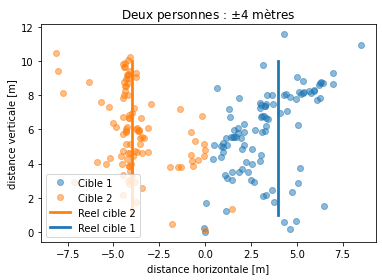

coordonnee moyenne pour la personne 1 du ficher CSm_straightline_4m-4m.npz : (x; y) = (3.273; 5.789) / (r; θ) = (6.650; 29.480°)
coordonnee moyenne pour la personne 2 du ficher CSm_straightline_4m-4m.npz : (x; y) = (-3.730; 5.914) / (r; θ) = (6.992; -32.235°)


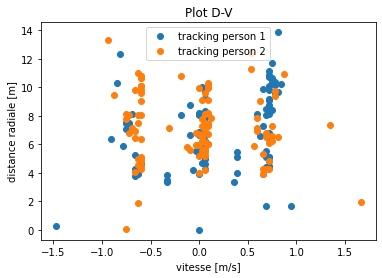

coordonnee moyenne pour la personne 1 du ficher CSm_straightline_4m-4m.npz : (0.182; 6.865)
coordonnee moyenne pour la personne 2 du ficher CSm_straightline_4m-4m.npz : (-0.027; 7.189)


In [10]:
lim_x_min = -5
lim_x_max = 5
if plotXY:
    plt.figure()
    # plt.title('Deux personnes : carré et cercle centré à 8 mètre et $\pm 30^{\circ}$')
    # plt.title('Deux personnes : 2 --> 10 mètres à $40^{\circ}, -30^{\circ}$')
    plt.title('Deux personnes : $\pm 4$ mètres')
    for count, c in enumerate(mcolors.TABLEAU_COLORS.values()):
        if count >= nb_object:
            break
        plt.plot(x[:,count], y[:,count], "o", alpha = 0.5, color=c, label = "Cible {}".format(count+1))
    
    plt.plot([-4, -4], [1, 10], linewidth = 2.75, color = "tab:orange", label = "Reel cible 2")
    plt.plot([4, 4], [1, 10], linewidth = 2.75, color = "tab:blue", label = "Reel cible 1")
        
#     plt.plot([-6, 6], [1, 10], linewidth = 2.75, color = "tab:orange", label = "Reel cible 2")
#     plt.plot([6, -6], [1, 10], linewidth = 2.75, color = "tab:blue", label = "Reel cible 1")

#     plt.plot([-1.28558, -6.42788], [1.53209, 7.66044], linewidth = 2.75, color = "tab:orange", label = "Reel cible 2") #40^o
#     plt.plot([-1, -5], [1.73205, 8.66025], linewidth = 2.75, color = "tab:orange", label = "Reel cible 2")             #30^0
#     plt.plot([1, 5], [1.73205, 8.66025], linewidth = 2.75, color = "tab:blue", label = "Reel cible 1")                 #-30^o

#     plt.plot([-2, -2, -6, -6, -2], [9, 5, 5, 9, 9], linewidth = 2.75, color = "tab:orange", label = "Reel cible 2")    #carre
#     ocircle = np.linspace(0,2*np.pi,150)                                                                               #cercle
#     xcircle = 4 + 2*np.cos(ocircle)
#     ycircle = 7 + 2*np.sin(ocircle)
#     plt.plot(xcircle, ycircle, linewidth = 2.75, color = "tab:blue", label = "Reel cible 1")

    plt.xlabel("distance horizontale [m]")
    plt.ylabel("distance verticale [m]")
#     plt.xlim([lim_x_min, lim_x_max])
#     plt.ylim([-0.5, lim_d_max])
    plt.legend(loc = "lower left")
    plt.savefig("Multicible/Plot_XY/plot_{}_nb_objects_{}.pdf".format(os.path.basename(file), nb_object))
    plt.show()
    
    for i in range(nb_object):
        x_mean = np.nanmean(x[:,i])
        y_mean = np.nanmean(y[:,i])
        print("coordonnee moyenne pour la personne {} du ficher {} : (x; y) = ({:.3f}; {:.3f}) / (r; θ) = ({:.3f}; {:.3f}°)".format(i+1, os.path.basename(file), x_mean, y_mean, np.sqrt(x_mean**2 + y_mean**2), radToDeg(np.arctan(x_mean/y_mean))))

if plotDV:
    plt.figure()
    plt.title("Plot D-V")
    for count, c in enumerate(mcolors.TABLEAU_COLORS.values()):
        if count >= nb_object:
            break
        plt.plot(vmax[:,count], dmax[:,count], "o", color=c, label = "tracking person {}".format(count+1))
    plt.xlabel("vitesse [m/s]")
    plt.ylabel("distance radiale [m]")
#     plt.xlim([lim_v_min, lim_v_max])
#     plt.ylim([-0.5, lim_d_max])
    plt.legend()
    #plt.savefig("Plot_DV/plot_{}_nb_objects_{}.pdf".format(os.path.basename(file), nb_object))
    plt.show()
    
    for i in range(nb_object):
        print("coordonnee moyenne pour la personne {} du ficher {} : ({:.3f}; {:.3f})".format(i+1, os.path.basename(file), np.nanmean(vmax[:,i]), np.nanmean(dmax[:,i])))